<h1 align=center> Tarea 8: Reducción de Dimensionalidad
 </h1>

Integrantes:
- Axel Mondaca
- Sebastián Hernández

In [182]:
%pip install umap-learn
%pip install -U spacy

import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.impute import SimpleImputer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [183]:
df = pd.read_csv('customers_Tarea8.csv')
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [184]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")
df["Year"] = df["Dt_Customer"].dt.year
df["Month"] = df["Dt_Customer"].dt.month
df["Day"] = df["Dt_Customer"].dt.day
df = df.drop(columns=["Dt_Customer"])
X = df.drop(axis=1, columns=["Response"])
X2 = df
y = df['Response']


In [185]:
numerical = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical = X.select_dtypes(include=['object', 'category']).columns.tolist()

preproc = ColumnTransformer(
    [("num", Pipeline([("imputer", SimpleImputer(strategy='mean')), ("scaler", StandardScaler())]), numerical),
     ("cat", Pipeline([("imputer", SimpleImputer(strategy='most_frequent')), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))]), categorical)]
)
X_processed = preproc.fit_transform(X)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=254, stratify=y)

### PCA, Principal Component Analysis

In [187]:
#Sin reduccion
rf_pipe = Pipeline([
    ("preproc", preproc),
    ("clasificador",RandomForestClassifier(random_state=254))])

rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       381
           1       0.65      0.42      0.51        67

    accuracy                           0.88       448
   macro avg       0.78      0.69      0.72       448
weighted avg       0.87      0.88      0.87       448



In [188]:
#Con reduccion de dimensionalidad
rf_pipe_pca = Pipeline([
    
    ("preproc", preproc),
    ("red_dim", PCA(n_components=0.90, random_state=254)),
    ("clasificador",RandomForestClassifier(random_state=254))])

rf_pipe_pca.fit(X_train, y_train)
y_pred_pca = rf_pipe_pca.predict(X_test)
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       381
           1       0.59      0.36      0.44        67

    accuracy                           0.87       448
   macro avg       0.74      0.66      0.68       448
weighted avg       0.85      0.87      0.85       448



In [189]:
pca = rf_pipe_pca.named_steps['red_dim']
cant_componentes = pca.n_components_
print(f"Cantidad de componentes: {cant_componentes} y varianza explicada: {np.cumsum(pca.explained_variance_ratio_)[-1]*100:.3f}%")

Cantidad de componentes: 18 y varianza explicada: 90.931%


In [190]:
def plot_reduction(X_reduced, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Response')
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.show()

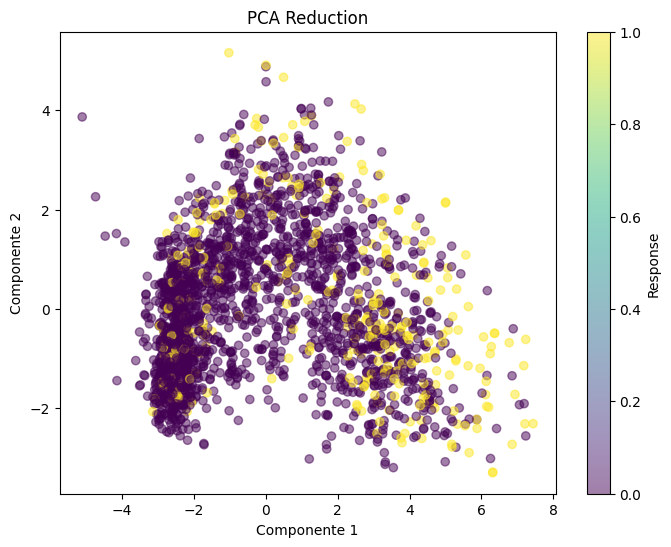

In [191]:
pca_2 = PCA(n_components=2, random_state=254)
X_pca_2 = pca_2.fit_transform(X_processed)
plot_reduction(X_pca_2, y, "PCA Reduction")

### t-SNE

In [192]:
tsne = TSNE(n_components=2, random_state=254)
X_tsne =tsne.fit_transform(X_processed)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y, test_size=0.2, random_state=254)

lr_tsne = LogisticRegression(random_state=254)
lr_tsne.fit(X_train_tsne, y_train_tsne)
y_pred_tsne = lr_tsne.predict(X_test_tsne)
print(classification_report(y_test_tsne, y_pred_tsne))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       382
           1       0.00      0.00      0.00        66

    accuracy                           0.85       448
   macro avg       0.43      0.50      0.46       448
weighted avg       0.73      0.85      0.78       448



C:\Users\seba0\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\seba0\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\seba0\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

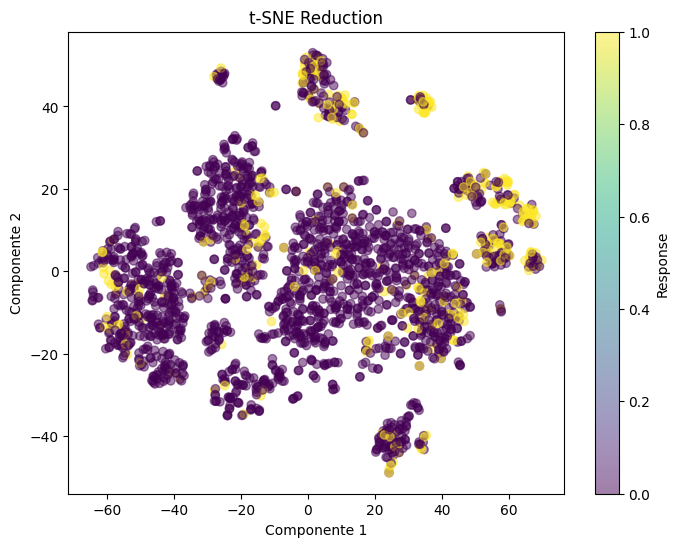

In [193]:
plot_reduction(X_tsne, y, "t-SNE Reduction")

### UMAP

C:\Users\seba0\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


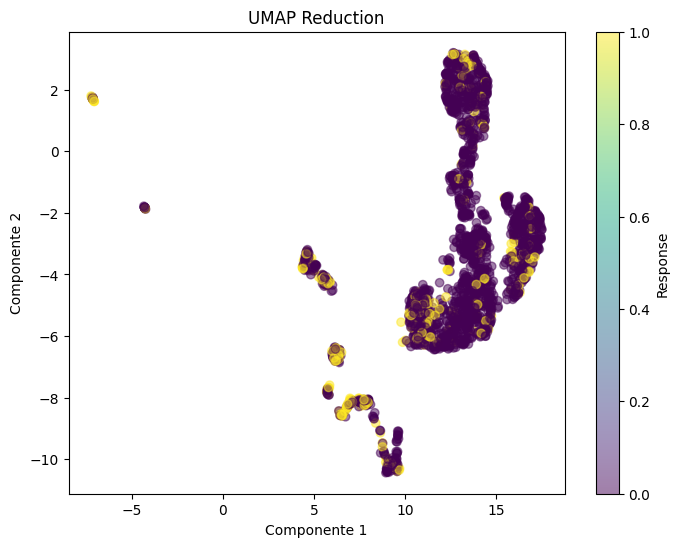

In [194]:
umap_model = umap.UMAP(n_components=2, random_state=254)
X_umap = umap_model.fit_transform(X_processed)

plot_reduction(X_umap, y, "UMAP Reduction")

In [195]:
# PCA que capture 90% de varianza
pca_var90 = PCA(n_components=0.90, random_state=42)
X_pca_var90 = pca_var90.fit_transform(X_processed)
print('Número de componentes para 90% varianza:', pca_var90.n_components_)


Número de componentes para 90% varianza: 18


## 2)  Modelos de clasificación

In [198]:
def entrenarRL(X_tr, X_te, y_tr, y_te, max_iter=2000):
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    return accuracy_score(y_te, preds), model, preds

#Entrenamos los modelos
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_pca_var90_train, X_pca_var90_test, y_pca_var90_train, y_pca_var90_test = train_test_split(X_pca_var90, y, test_size=0.2, random_state=42)
X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)
X_umap_train, X_umap_test, y_umap_train, y_umap_test = train_test_split(X_umap, y, test_size=0.2, random_state=42)

#Obtenemos la accuracy de los modelos
accuracy_sin_red, model_sin_red, preds_sin_red  = entrenarRL(X_train, X_test, y_train, y_test)
accuracy_pca_var90, model_pca_var90, preds_pca_var90 = entrenarRL(X_pca_var90_train, X_pca_var90_test, y_pca_var90_train, y_pca_var90_test)
accuracy_tsne, model_tsne, preds_tsne = entrenarRL(X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test)
accuracy_umap, model_umap, preds_umap = entrenarRL(X_umap_train, X_umap_test, y_umap_train, y_umap_test)

print('Accuracy para modelo sin reducción:', accuracy_sin_red)
print('Accuracy para modelo con PCA 90%:', accuracy_pca_var90)
print('Accuracy para modelo con t-SNE):', accuracy_tsne)
print('Accuracy  para modelo con UMAP):', accuracy_umap)

Accuracy para modelo sin reducción: 0.8616071428571429
Accuracy para modelo con PCA 90%: 0.8638392857142857
Accuracy para modelo con t-SNE): 0.8504464285714286
Accuracy  para modelo con UMAP): 0.8504464285714286


el impacto de la reducción de dimensionalidad en el entrenamiento previo es

## 3)  Selección de modelos

In [197]:
resultados = pd.DataFrame({
    'Modelo': [
        'Regresión Logística sin reducción',
        'Regresión Logística con PCA',
        'Regresión Logística con t-SNE',
        'Regresión Logística con UMAP'
    ],
    'Accuracy': [accuracy_sin_red, accuracy_pca_var90, accuracy_tsne, accuracy_umap]
})
resultados

,Modelo,Accuracy
0,Regresión Logística sin reducción,0.861607
1,Regresión Logística con PCA,0.863839
2,Regresión Logística con t-SNE,0.850446
3,Regresión Logística con UMAP,0.850446


Considerando lo anterior, el mejor modelo es el modelo de regresion logistica con PCA al tener un valor de 0.863839, lo que lo deja arriba de los otros 3 modelos por aproximadamente 0,002 para RL sin reduccion y 0,01 para los modelos RL con t-SNE y UMAP